<a href="https://colab.research.google.com/github/Isaac-Jacobson/snow/blob/main/StreakDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Snowflake Streak Detector

In [ ]:
#Bonus cell just for executing linux commands on collab




#Setup

In [ ]:
#Install dependecies

!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30
!pip install -q tflite-model-maker
!pip install -q tflite-support


In [ ]:
#Needed imports although matplotlib, numpy,and pandas aren't currently used but will probably be needed
import tensorflow as tf

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import numpy as np
import pandas as pd
import matplotlib as plt

import os
from os import listdir
import cv2
from cv2 import threshold
from cv2 import HoughLines
from google.colab.patches import cv2_imshow

from skimage import measure
import math
import scipy


#Get the data and base model

In [ ]:
#Picking what base model to use, efficientdet is just a starting place
#spec = model_spec.get('efficientdet_lite0')
#spec = model_spec.get('efficientdet_lite2')
spec = model_spec.get('efficientdet_lite4')

In [ ]:
#Get dat data
#!curl -L "https://app.roboflow.com/ds/fosD79eC34?key=xH3OhXG8fK" > data.zip
#!unzip data.zip; rm data.zip
#!curl -L "https://app.roboflow.com/ds/1XRSjPxvAk?key=B8s0tsnsPH" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
#!curl -L "https://app.roboflow.com/ds/RQYEC5i0Na?key=djTi5csoOX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L "https://app.roboflow.com/ds/7NzUVnpDY1?key=Dnyi0VIAMR" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   1754      0 --:--:-- --:--:-- --:--:--  1754
100  183M  100  183M    0     0  72.8M      0  0:00:02  0:00:02 --:--:--  102M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/Flake03_png.rf.0742e401ac6b266a0599088b430dec06.jpg  
 extracting: test/Flake109_png.rf.35a7f7248bb9c5ee4bbfd8ed5f090a44.jpg  
 extracting: test/Flake115_png.rf.62c1a97434c51182bc4c8cb6a9b7e52a.jpg  
 extracting: test/Flake127_png.rf.04bb9e61ed77ac14e611e9a9cfe9a77e.jpg  
 extracting: test/Flake133_png.rf.7ad4224ffeec34b26dc666fd4a355230.jpg  
 extracting: test/Flake144_png.rf.edf3c9261775cf228c9d354bd540ac01.jpg  
 extracting: test/Flake147_png.rf.2403b00d4804a026f43ae0db2c89a77c.jpg  
 extracting: test/Flake150_png.rf.3ee0da42a159104ec3fbdd

In [ ]:
#I'm working on automating the jpeg and csv manipulation but right now I still hand format the csv

#!mkdir data
!mv ./test/*.jpg .
!mv ./train/*.jpg .
!mv ./valid/*.jpg .
!rm ./test/*.csv
!rm ./train/*.csv
!rm ./valid/*.csv
!rmdir ./test 
!rmdir ./train 
!rmdir ./valid

#!rm ./merged.csv
#!head -n 1 ./annotation/train.csv > merged.csv && tail -n+2 -q ./annotation/*.csv >> merged.csv

#Pre Processing
Binarize all the images before training

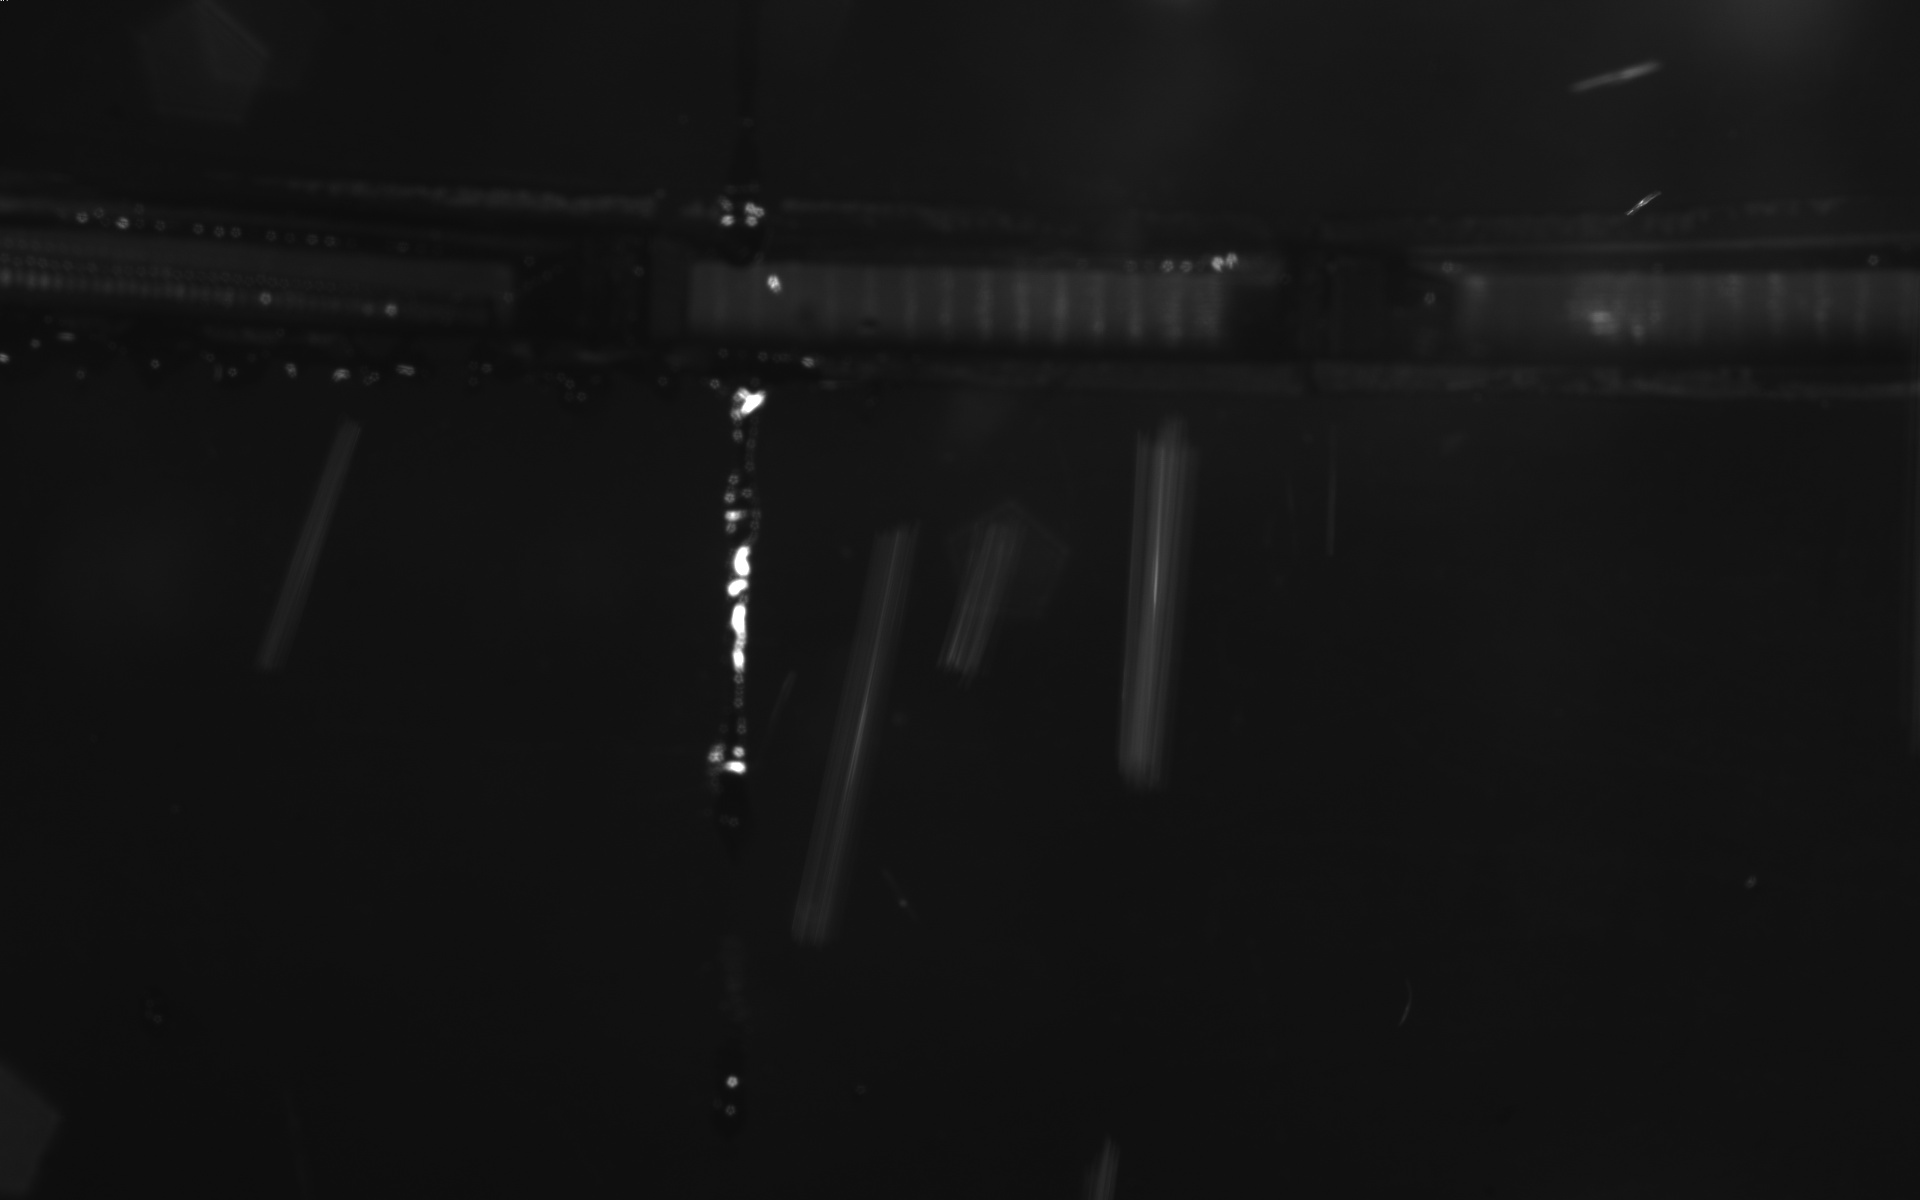

In [ ]:
bg = cv2.imread('Flake000016_Cam1_2_2022-1-28-23-43-5-821.png')
#fg = cv2.imread('Flake01.png')
cv2_imshow(bg)
#cv2_imshow(fg)

In [ ]:
#processes the image, saves it as a png, lots of thresholds!!!
def simplify(img, background, cnt=0):
  #background subtraction
  smpImg = cv2.subtract(img, bg)
  print("subtraction:")
  cv2_imshow(smpImg)

  #Binarize the image
  ret1, binImg1 = threshold(smpImg, 20, 225, cv2.THRESH_BINARY)
  print("binarized 1:")
  cv2_imshow(binImg1)
  #blur groups of pixels into blobs
  blur = cv2.GaussianBlur(binImg1,(19,19),0)
  print("Blurred:")
  cv2_imshow(blur)
  #binarize the image again
  ret1, binImg2 = threshold(blur, 150, 255, cv2.THRESH_BINARY)
  print("binarized 2:")
  cv2_imshow(binImg2)
  #save it to a png
  #filename = "./flake" + str(cnt)
  cv2.imwrite("testFlake", binImg2)

In [ ]:
simplify(fg, bg)

In [ ]:
folder_dir = "."
count = 0;
for image in os.listdir(folder_dir):
  if (image.endswith(".png")):
    count += 1
    simplify(image, bg, count)

#Train and test

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('./annotations.csv')

In [ ]:
print(test_data.label_map)

#Output should be: {1: 'class', 2: 'Streak'} if not check the annotations file

In [ ]:
# train_whole_model, controls layers being trained, setting to false uses transfer learning to train and
# only trains layers that don't match model_spec.config.var_freeze_expr.
model = object_detector.create(train_data, model_spec=spec, epochs = 12, batch_size=5, train_whole_model=True, validation_data=validation_data)

In [ ]:
model.summary()
#There should be 15,108,198 parameters if using lite4

#Test

In [ ]:
#Needs a bigger test set

#Prints mAP for whole model and specifically for each piece (class)
model.evaluate(test_data, batch_size=1)
#print (model.predict(test_data))

#Making and Testing the tflite version

In [ ]:
# Defaults to post training full integer quantization when exported to tflite file
model.export(export_dir='.')

#You can download the model this way

In [ ]:
#Prints mAP for whole model and specifically for each piece (class)
model.evaluate_tflite('model.tflite419', test_data)

NameError: ignored

#Bounding Box based Slope 
not used

In [ ]:
#Count the number of pixels (above threshold) in the bottom squares of the given array
def countPixels(arr, pixelThreshold=50, testSize=0.45):
  cnt1 = 0
  cnt2 = 0
  height = len(arr)
  width = len(arr[0])
  square = int(min(width, height) * testSize)

  for i in range(height-square, height, 1):
    for j in range(0, square, 1):
      if(arr[i][j][0] >= pixelThreshold): cnt1 += 1

  for i in range(height-square, height, 1):
    for j in range(width-square, width, 1):
      if(arr[i][j][0] >= pixelThreshold): cnt2 += 1   

  return cnt1, cnt2  

In [ ]:
def findBoxSlope(img, xmin, ymin, xmax, ymax, pixelThreshold=30, verticalThreshold=0.3, testSize=0.45):
  img = img[ymin:ymax, xmin:xmax]
  cnt1, cnt2 = countPixels(img, pixelThreshold, testSize)
  print("Counts: " + str(cnt1) + "   " + str(cnt2))
  slope = (ymax-ymin)/(xmax-xmin)
  if(cnt1 > ((1+verticalThreshold) * cnt2)):
    #positive slope
    return slope
  elif(cnt2 > ((1+verticalThreshold)*cnt1)):
    #negative slope
    return -1*slope
  else:
    #vertical streak
    return 0 #represents a vertical streak because we should never have a horizantal one

#Sampling Slope

In [ ]:
# NOT USED
#Finds the width of a "streak" in the binarized array
def findStreakWidth(arr):
  lptr = 0
  rptr = 0
  flag = True
  for i in range(0, len(arr)):
    if(arr[i] == 1):
      if(flag):
        flag = False
        lptr = i
      rptr = i
  return int(rptr - lptr)

In [ ]:
#Finds the midpoint of a streak in the binarized array with a left pointer reset after 5 dark pixels in a row
def findMidpoint(arr):
  lptr = 0
  rptr = len(arr)
  flag = True
  cnt = 0
  for i in range(0, len(arr)):
    if(arr[i] == 1):
      cnt = 0
      if(flag):
        flag = False
        lptr = i
      rptr = i
    else:
      if(cnt==5):
        flag = True
        cnt = 0
      cnt+=1

  if((lptr==0) and (rptr==len(arr))):
    return -1
  else:
    return int((lptr+rptr)/2)

In [ ]:
#Takes the list of points and finds the slope between each pair than averages the slope
#A poor-mans line line of best fit
def slopeFromPoints(points):
  n = len(points)
  cnt = 0
  total = 0
  for i in range(0, n-1):
    if((points[i][0]!=-1) and (points[i+1][0]!=-1)):
      rise = abs(points[i+1][1] - points[i][1])
      run = abs(points[i+1][0] - points[i][0])
      if(run != 0):
        slope = rise/run
      else:
        #Vertical slope encoding ***FIX ME***
        slope = 100
        print("Vertical segment, check results!")
      total += slope
    else:
      cnt+=1
  if(n-cnt-1 <= 0):
    return 0
  return total/((n-cnt)-1)

In [ ]:
#Binarize and FLATTEN the provided array 
def binarize(img, lower=25, upper=255):
  newImg = []
  for i in range(len(img)):
    inner = []
    for j in range(len(img[0])):
        inner.append(0)
    newImg.append(inner)
  for i in range(0, len(img)):
    for j in range(0, len(img[0])):
      if((img[i][j][0] > upper) or (img[i][j][0] < lower)):
        newImg[i][j] = 0
      else:
        newImg[i][j] = 1
  return newImg

In [ ]:
#Uses the n-sampling method to find the slope of the streak in the given bounding box
def findSampleSlope(img, xmin, ymin, xmax, ymax, n=7):
  img = img[ymin:ymax, xmin:xmax]
  binImg = binarize(img, 25, 255)
  midpoints = [(0,0)]*n
  height = ymax-ymin
  step = int(height / (n+1))
  for i in range(0, n):
    y = i*step
    midpoints[i] = (findMidpoint(binImg[y][:]), y)
  return slopeFromPoints(midpoints)

#Testing

In [ ]:
import cv2

from PIL import Image

model_path = 'model419.tflite'

# Load the labels into a list
#classes = ['???'] * model.model_spec.config.num_classes
#label_map = model.model_spec.config.label_map
#for label_id, label_name in label_map.as_dict().items():
#  classes[label_id-1] = label_name
classes = ['Streak', 'Streak']

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    slope = findSampleSlope(original_image, xmin, ymin, xmax, ymax, 7)
    if(slope == 100):
      print("Fully vertical streak detected!!!")
    #print("Slope for streak with confidence: " + str(obj['score']) + "  :  " + str(slope))

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}% {}: {:.3f}".format(classes[class_id], obj['score'] * 100, "Slope", slope)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8


In [ ]:
#!rm ../tmp/image.png

height: 263
step: 32
midpoints: 
[(-1, 0), (116, 32), (104, 64), (93, 96), (82, 128), (71, 160), (61, 192)]
height: 189
step: 23
midpoints: 
[(94, 0), (89, 23), (94, 46), (92, 69), (130, 92), (58, 115), (49, 138)]
height: 128
step: 16
midpoints: 
[(104, 0), (111, 16), (122, 32), (131, 48), (131, 64), (136, 80), (-1, 96)]
Vertical segment, check results!
height: 49
step: 6
midpoints: 
[(56, 0), (56, 6), (56, 12), (56, 18), (56, 24), (56, 30), (56, 36)]
Vertical segment, check results!
Vertical segment, check results!
Vertical segment, check results!
Vertical segment, check results!
Vertical segment, check results!
Vertical segment, check results!
height: 63
step: 7
midpoints: 
[(-1, 0), (54, 7), (55, 14), (53, 21), (54, 28), (50, 35), (48, 42)]
height: 437
step: 54
midpoints: 
[(253, 0), (245, 54), (239, 108), (243, 162), (126, 216), (115, 270), (103, 324)]
height: 135
step: 16
midpoints: 
[(80, 0), (85, 16), (82, 32), (45, 48), (45, 64), (44, 80), (44, 96)]
Vertical segment, check resu

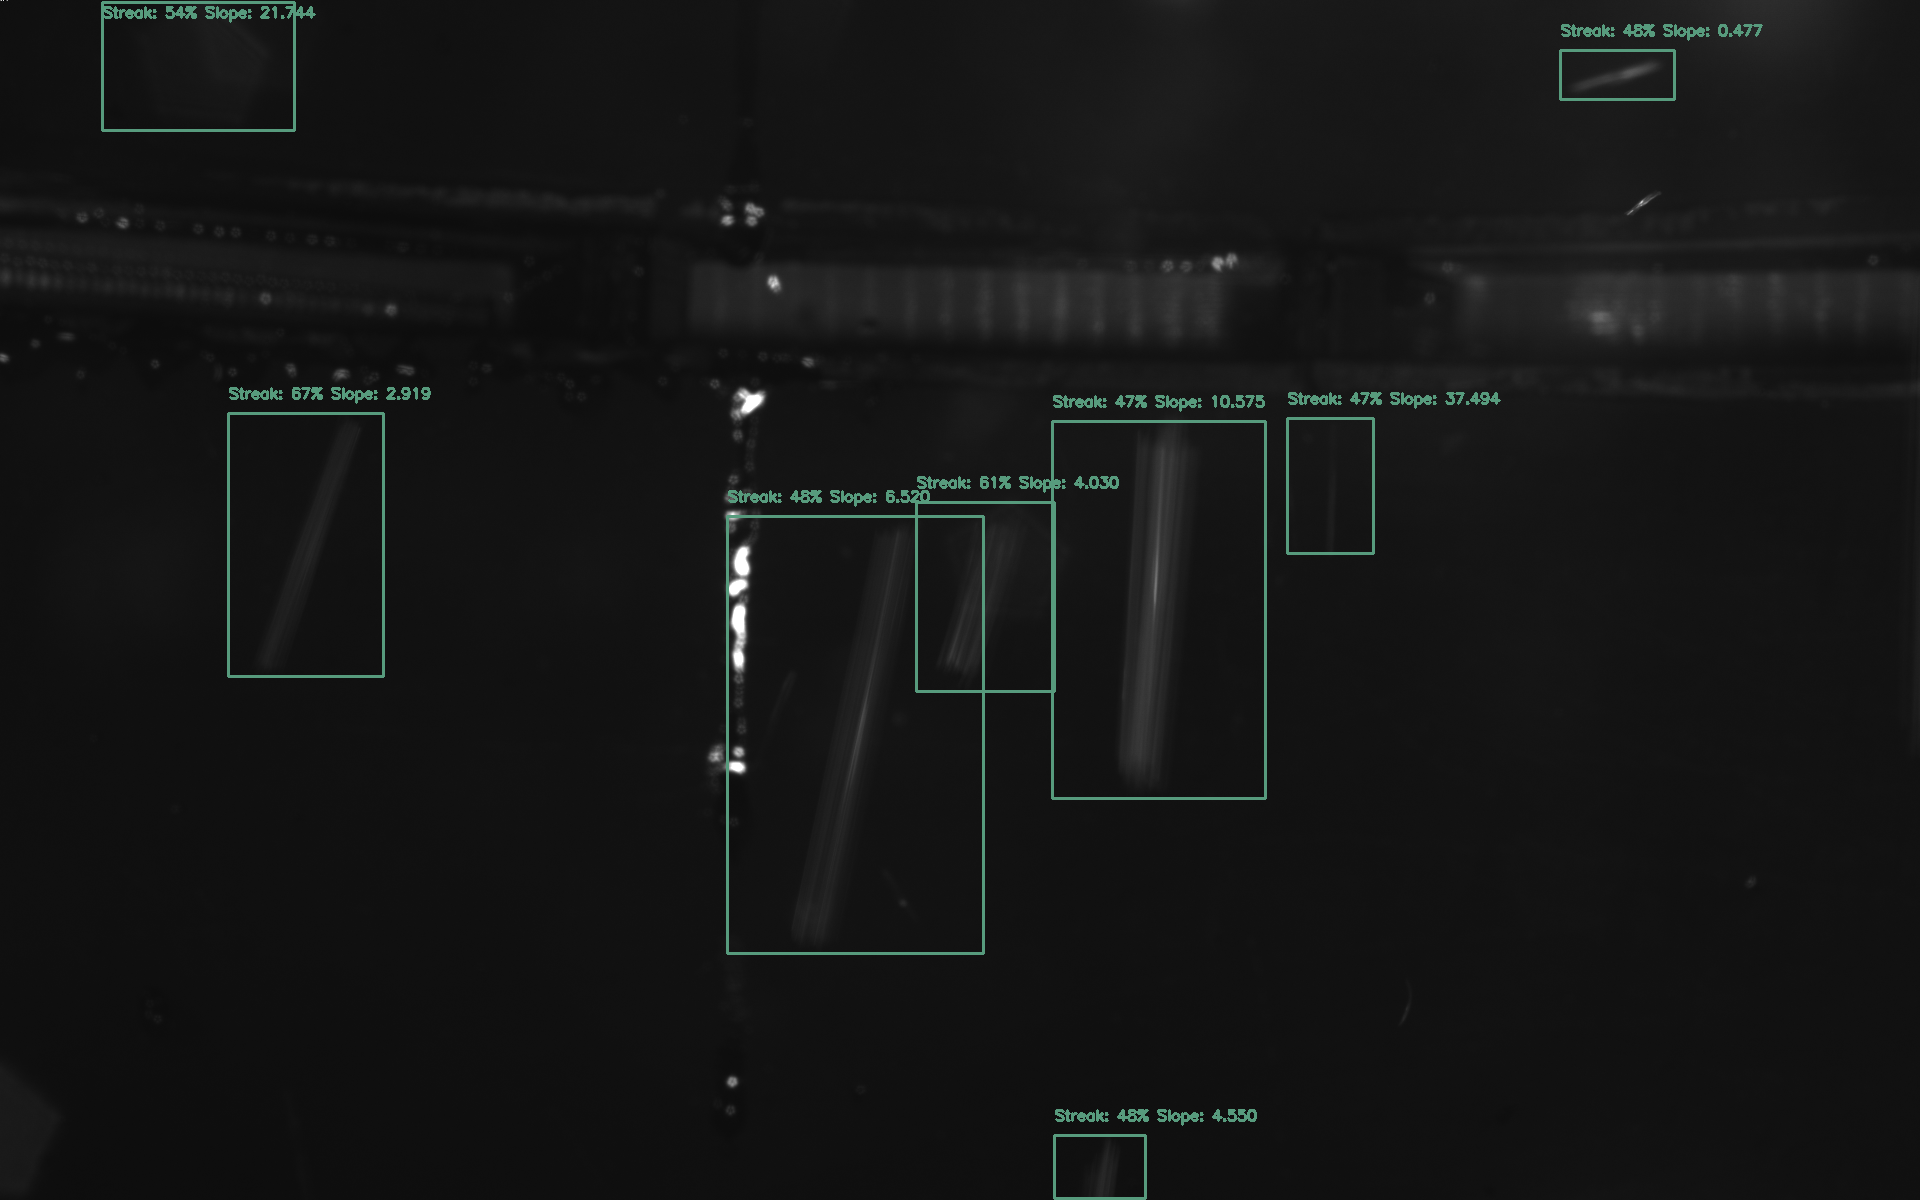

In [ ]:
#INPUT_IMAGE_URL = "https://lh3.googleusercontent.com/fife/AAWUweXhiNM-Wjycs4I9azVLpApZIPTVlfYuEybDWngIaQzzJKwktIZMcNPfBCtuZF8-aZL9pX5F2HxKZDIn9GRbA6OH_Gqg3MEI3-twVk9mgJSlBSqs7Q1mPZu98L6EdrFTNhBgz9g8AS6Nahf4BrOLcYHq1vqPr4lUCq7CS2xAGcxhQ6bq85KtySX6l8zTkyJG7Dm5LL_tUH4mU4EguXcIy4s6ndN3irIXps53Cvu9ALO77Meig0xFS-ev63M4RFIyg98KwN6FyQiTlj4ul3EnePDG2SIoEWnnaau5dEHNBBfR5ggwmRs3Iv_gpJJf6V-DTzl8JL5SoZvP65JaFBI78MMZCrYk1IrXeawpTpTE-4Awv7kdn4SPokv2P9aT7m77fnCrJiMhraIUwchLkHh-KhQJvN1WH0evX2uQIxMsjYQBCs6sbintF2mIWCXRRPD4VrGQL5ziqP-PsgFteKFP7oWyWTDW7Yt6_FVTTWxxXBVUZRhcv8xfMogzf9l7NaUrZRAo5zlrGG6uSI5niGEmaCj-HqM99D5m9G3QK_vsNxIr1aZUXRhaMseLOXaFrxEE8ZxQiIGLX4mNzLb0X4GWWXBKR7il8VqFKNcqhaX1N6Asgex9FQLLsa87iqCS352sJ7640B0YUCv-B1F91_BTjuj4IwwGxUjtS9avSVhJzRVNqh3lEF4_4wD89oP5jgWaUAAwenRKIZ-eT8lAe403wGTLsTF19nrkkJxJyxLFrt-JTiP0uGyD_P7nIIbWTkpd196kY2iEB2B0zlJGahWGFoRPg5BIhU8jG8d_tbdBV9dn77il_VTgZgk_fg2yRh7O9V_VJ_ox1nHZSAZ73AZDJS6MuW9bqNRpUy24eg2nEJPvOmPro4mKBoKitHAeEEC0LlABW7H_tzS0yQoe9DZYVS9XHGgVuWqzrkKGN4j7O4s9S92-wF44okHuwWWevHSU4wBUC3tChArSC9u_BuBIGsdigx1FwhV1vz72F0zl0oPzNT9CRITkYSf7ey1vULl9X5JF2jYUpKtDrplDnEDjEP49v8fqhMdF-G7vQRYzR_VB0CnnOxXvhCfjca2BP4ScgCb20tkpR_kFCkkA6tx5V1Du3k0u3_sd5T6n-a7A9L9YytyeeSysq02PXcfYYtjZDhKbtGdEfL8bMcAQav31vZlxr-Nt1ZyKeYARehPMCkhxIiWIFIi-9LAMcQC3MF6DqWLRzqlksJi8aUhZWreAISxs0rN83d_VgY3cWk3bLGTRw6SopWbQn1PGLvTQrrNaCaZJy8AajYyjdK8xGdiV4M53Xsq2GgNJO8_JracsKIFJsYBOV-qNNuYys8ISeJnUqlELwBVRJnFqh7E3A1cWgz8RLomnC6OIAOLPL3mk4gn-KmxrfATAcdJB_6g9dRn6CPxM-Eb7UFtmP9y0XXVsyxLT9jlpPhooCabvMieDQmjWHaSIbbURsVJpAJ42Q8DSBX5lB-qpAwHBN8-bPVgNhflbYUJ0gCFNIsPOz14DsZXJGlA5NWcu3OTjqgGPePnVfqK2DCTa36AVKjgogELBTq68QvMO5XNs5SbzOoj-oHwalshfi48iCoag1H4DwQZgvBZYV_AsYOemqGgvYEi1cVvDt-2gWPZdwBLngyZTAjQxj6KY1Z3y6C9mZROn4lzrxoN83jNFpUEir7WUlT0w_fBegzncvJzAgjFZq3AtsdENSd4yqWGTQ5cMW5Qay4Kq7t7zukQlH30owKEx8EX4iidImc8GBD_0nyGfdELuJvl4Z90OWzbqC8ASsseWz3WQw35dQ0SiVSAVw_94e-yXaKaxC93WGv5UQStxxSJLxF6gfvt1r1FyNvimHoHsp3CdOA4_3S0IPChHPF1ZiTJtfmMApfbgF1GI3DCxSg4w4fpZFd1RlAWNW9GVWZWeQxf0qfcwVjh0sFJQ3eZ3yfuyrDMmcgSf0jKJEIQF_wnMhfrTe8qiE3UIoHMa5BO-HCs5CCz9veHdZ2YiZsj41TefcDeNX6bPeCl2xoNw3x_Iy_V-dT30n0mxZO5n-iC6_5DQp9iFxD5SfJOWFQrDd-okbM3tRMSw3HF-zsWFzctbz8O6q7-I4GmMYdonsuWKU6JMTVDLe-DQYLzVCVKc9kbpIU5zTREBCHw6phcllawlGOhaAaEhU-6bmRhVq5N5MzvCCsmpcy0Mr4EYj5I3XIOlR9mEVh3THscDg7cxKQDaWMRPsCrf-xONmhqTW9GXhISkpqpS4-yKTjEhkbls08ybkK5nkJOf7bx389mmXHzDy9xl3LVdHVF2LQagc7HbCv2Up2qlO9Ralj8GNU_9oibWWPDeggfM5lpWY7Sr1uegOgoZHjDq_ezavy6LEhzpGpDdf8o_VMaLFozb50Or99qyry4HXkRfhVsnfmLZPN0jJITZKhrh_E03WrfHyiDkwGpaMCaqbQvKGGiKUpwpRfo4YdYmQRCZ0mUUJRCuZcKv_yLGsOMltzw2XL23yaflD5EG2_9YNsdfiyR3slD3Y-FVHMXIn_nkmXqyvpI-FhF3rTsjr6s5qySEigKtDW1oYhdxWPciqgXkK-xxYIKVTEMX5I8L0shC-LXjouTgDC7GYaRGu376kp_3mKKOwZ-BxsEUsD9ygLu3XoHqBM8qM8oqfcUTHPjOcWPV29TaGKsUM8aptQIwYCq1syIB1_3ERc-hjdKZou-d4OY2iYKlmbGFcuOQ4Ws4dwMukqDdd_PX5-vPUY9pCZtgRPqb21mNUpHxlVeZjGCBi71uAolZFLyPz12-GR7V8TC8wxEInmMrNum70AfTrmELZijA1uj3_Em8LTo62v3h4Y3BQzuPNkD2K8snj8B0hwfyhzAkuQ_sRbaWHsGJDrMkpjVqHOen9SBxBp9KJYtFAQNCFtK3aKH0ZjjEdjoPs9EH8XmKK9hZFmi95w2zkL1h9pz8SwYFbN7ChRdY4GdD7JtG0c4MnHCOtKcquoHkbnPDTM_tX8wfa9uJXRTwUZyOA1XSvgRVTsyLBirDea8EnyzUrAt-YlppaANu2Sd5pH7djT3yjRIr_X8HOQxqs6sX1fenJcCjg8KqR1BeNZ0mHu857ob-1vhtzvpr2NQW83LeLCxKVbkLYsR8EmJ5QtK9qDOMCNJSbfW9HSy1qg90C-qF3UAtHs7-xysaKVFQoBWIhx5m2CEqpEm88ibTUofx85EFqlQKTr-aC97hCJRmKmxDlwsfvKdhlScPuNEHIchhzqoq0nIeMDBcFBYxs4JbzOQb-ur0CXvUS64SDC-k1eFS1jEwCDuHABhruF3JrnnXd4vsdUIn9j7D1FIqv40jIkuh6yYjg3xGUr9a5zkcZRcbboXqPKc4EvsZb5Jqi-W72gcPr2vxY5zPb1XPRPwTx0MAie3wSjtUikvZIN3o8D2MZl5disHZ9hipqya4l1ZWOnwZLoaCIkUm86QJK6KP67PgGy4CedIxcrvyrnMUyszEw_iuMQJdOnvx4VpF7SUzJDYnIBZiR4x2bSzKz42ox9QPQeDdNsE2TuVDaEjuxvPRvcuNlMTsnr-zo6XLXlXk9uYkTKXRjz72Bg-hn4kEJnDvkB0y1NUQjOsACZTAk-hA4x-qZhzxSl9TJcl-ajBYoJOz6hHvHjcFxBCjJLXsjh4LAmPe_bsstOCzTFXX7wsoo6yoNnsTBz3iigTConWqi7O9TiTqfjQkVc6k1Taoh6_NNpnZMUPI6JHAhWfY91mDLGzd-RMT2GQvPX8nRhNYvPdYpFrPIJB9VWQO5fvNVH6QHDBIEumaGBDmanL-zwFmtOOjHAi6wMz_p_1N3aZHFiw6uPxcGuP0T2M7E2IHrzbT4PlcGX7meuw2J4mtThkVavKlMvGwXQLo9jCQiXiPIg4gxbuMhlueCpdoNRGPzoFE0Q=s1920-w1920-h1200-no?authuser=1"
DETECTION_THRESHOLD = 0.45
TEMP_FILE = 'Flake000016_Cam1_2_2022-1-28-23-43-5-821.png'

#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
#im = Image.open(TEMP_FILE)
#im.thumbnail((1920, 1200), Image.ANTIALIAS)
#im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


#Leftovers

In [ ]:
#Unused at the moment (everything below this cell, and in it)****************************


# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


#Mount google drive for exports

In [ ]:
#link drive for easy saving, although just downloading the model is easier
from google.colab import drive
drive.mount('/content/drive')

#Playground



In [ ]:
#Helper function for drawing a bounded box on an image
def draw_rect(image, box):
    y_min = int(max(1, (box[0] * image.height)))
    x_min = int(max(1, (box[1] * image.width)))
    y_max = int(min(image.height, (box[2] * image.height)))
    x_max = int(min(image.width, (box[3] * image.width)))
    
    # draw a rectangle on the image
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)